In [83]:
from __future__ import print_function    # (at top of module)
import warnings
#warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

In [84]:
# Read the data from the file
data = pd.read_csv('data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [85]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [86]:
data = data[data.popularity > 50]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [87]:
from project_modules import *

final_data = label_data(data, 90)

Number of popular examples after thresholding :  47
Number of not popular examples after thresholding :  523


In [88]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_video_title', 'youtube_view_count','speechiness','instrumentalness','time_signature', 'danceability', 'key','duration','mode', 'liveness'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

In [89]:
final_data.head()

,energy,tempo,acousticness,loudness,valence,is_popular
0,0.840,115.062,0.2450,-3.651,0.520,0
1,0.541,124.959,0.5680,-6.825,0.448,0
2,0.804,104.823,0.0231,-6.327,0.426,0
3,0.788,170.019,0.0482,-4.323,0.839,0
4,0.745,94.014,0.3540,-3.695,0.820,0


In [90]:
# COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
#                     "speechiness", "acousticness", "instrumentalness", 
#                     "time_signature", "danceability", "key", 
#                     "duration", "loudness", "valence", "mode"]
COLUMNS_TO_SCALE = ["energy", "tempo","acousticness","loudness", "valence"]
# Keep data in a temp variable for testing
scaled_data = scale_data_normalize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
# plt.subplot(1,2,1)
# plt.plot(data['duration'])
# plt.title("Duration before scaling")

# plt.subplot(1,2,2)
# plt.plot(scaled_data['duration'])
# plt.title("Duration after scaling")
# plt.tight_layout()
# plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

,energy,tempo,acousticness,loudness,valence,is_popular
0,0.838293,0.360693,0.247690,0.807462,0.522258,0
1,0.502527,0.431906,0.574298,0.594084,0.444083,0
2,0.797866,0.287019,0.023312,0.627563,0.420195,0
3,0.779899,0.756132,0.048692,0.762286,0.868621,0
4,0.731611,0.209243,0.357908,0.804504,0.847991,0


In [91]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [92]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  285
Items in testing data set:  285


In [97]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score

models = [
          {'title':"Logistic regression", 'model':LogisticRegression(random_state=3)},
          {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3)},
          {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3))},
          {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3))},
          {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17)},
          {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17))},
          {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3)},
          {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced')},
          {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3))}
         ]

# Train-test split

Logistic regression

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


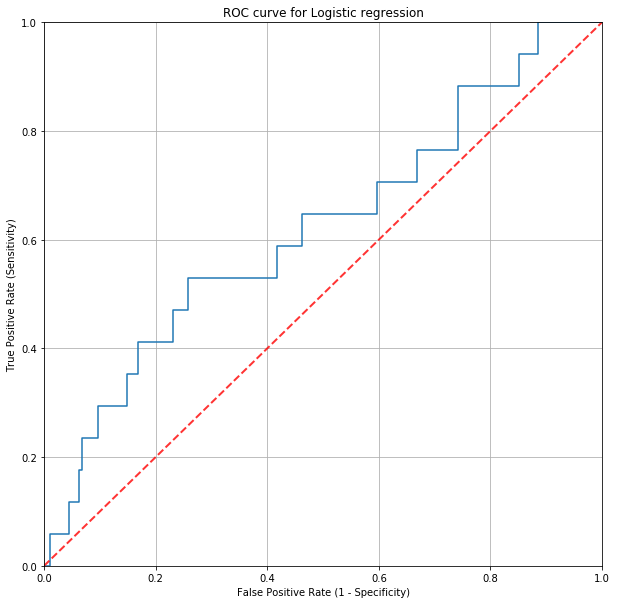

AUC score:  0.6202809482

Logistic regression balanced weights

Accuracy:  0.649122807018

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       268
           1       0.08      0.47      0.14        17

   micro avg       0.65      0.65      0.65       285
   macro avg       0.52      0.57      0.46       285
weighted avg       0.90      0.65      0.74       285

Confusion matrix: 
[[177  91]
 [  9   8]]


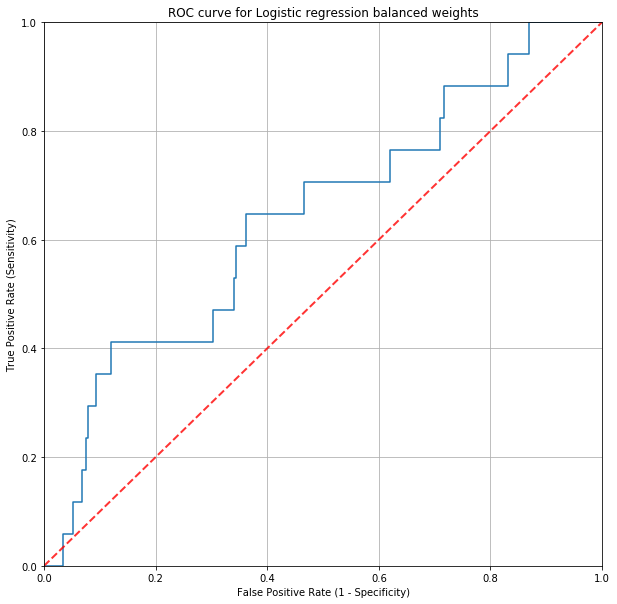

AUC score:  0.64244951712

Oversampling logistic regression

Accuracy:  0.656140350877

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       268
           1       0.10      0.59      0.17        17

   micro avg       0.66      0.66      0.66       285
   macro avg       0.53      0.62      0.48       285
weighted avg       0.91      0.66      0.75       285

Confusion matrix: 
[[177  91]
 [  7  10]]


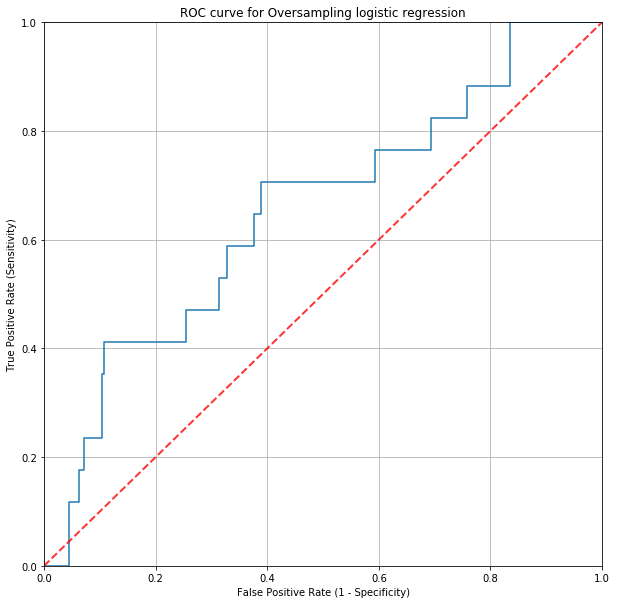

AUC score:  0.65188762072

Oversampling logistic regression balanced weights

Accuracy:  0.656140350877

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       268
           1       0.10      0.59      0.17        17

   micro avg       0.66      0.66      0.66       285
   macro avg       0.53      0.62      0.48       285
weighted avg       0.91      0.66      0.75       285

Confusion matrix: 
[[177  91]
 [  7  10]]


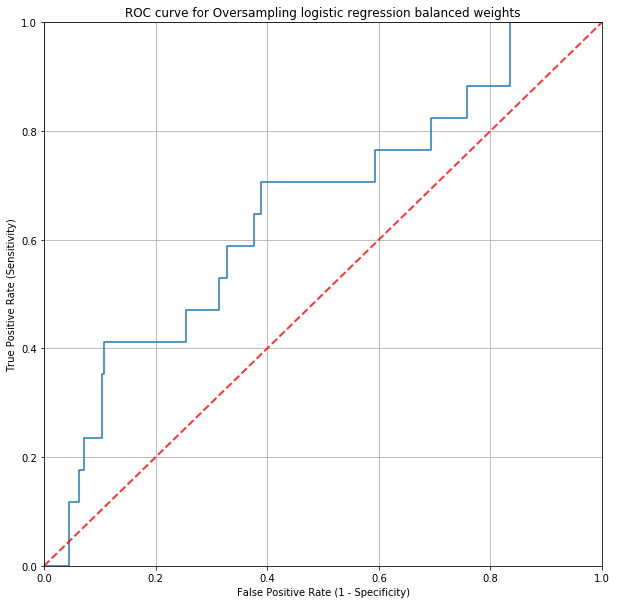

AUC score:  0.65188762072

KNN

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


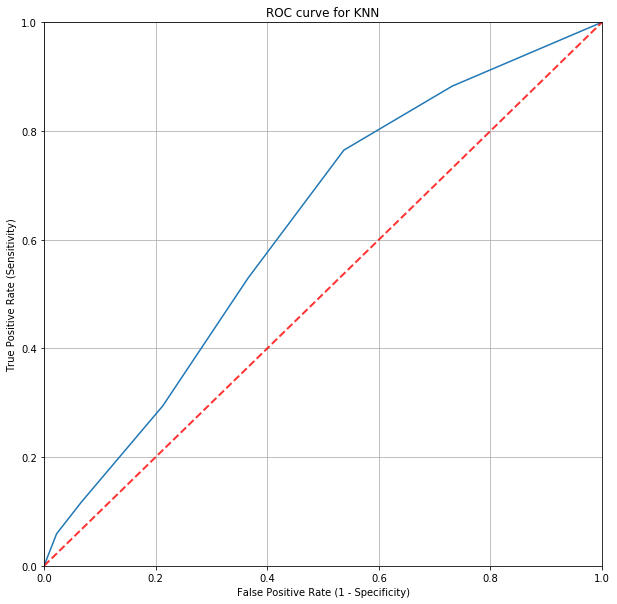

AUC score:  0.621268656716

Oversampling KNN

Accuracy:  0.561403508772

              precision    recall  f1-score   support

           0       0.95      0.56      0.71       268
           1       0.07      0.53      0.13        17

   micro avg       0.56      0.56      0.56       285
   macro avg       0.51      0.55      0.42       285
weighted avg       0.90      0.56      0.67       285

Confusion matrix: 
[[151 117]
 [  8   9]]


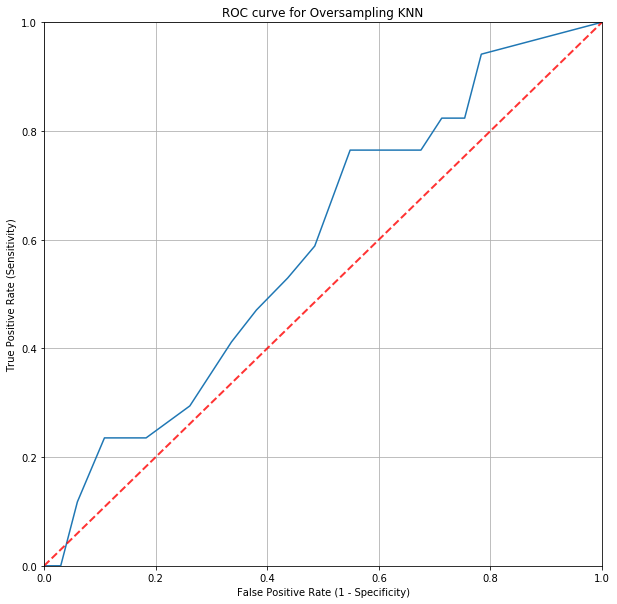

AUC score:  0.589552238806

SVM

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


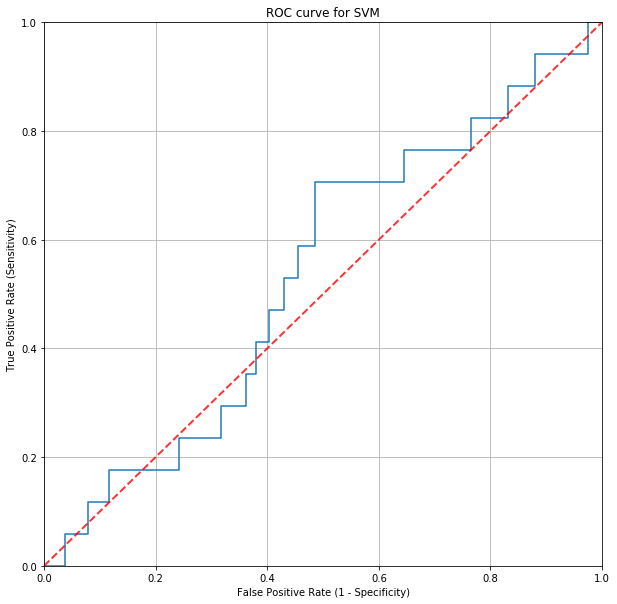

AUC score:  0.535996488147

SVM balanced weights

Accuracy:  0.617543859649

              precision    recall  f1-score   support

           0       0.96      0.62      0.75       268
           1       0.09      0.59      0.16        17

   micro avg       0.62      0.62      0.62       285
   macro avg       0.52      0.60      0.45       285
weighted avg       0.91      0.62      0.72       285

Confusion matrix: 
[[166 102]
 [  7  10]]


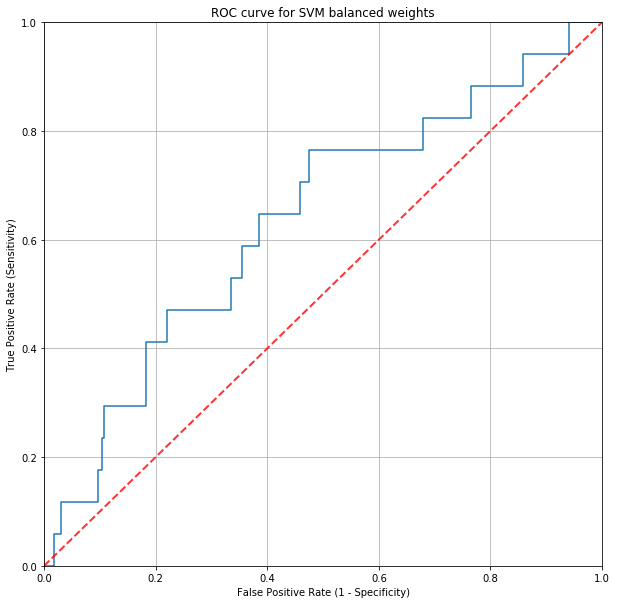

AUC score:  0.635645302897

Oversampling SVM

Accuracy:  0.59298245614

              precision    recall  f1-score   support

           0       0.96      0.59      0.73       268
           1       0.08      0.59      0.15        17

   micro avg       0.59      0.59      0.59       285
   macro avg       0.52      0.59      0.44       285
weighted avg       0.91      0.59      0.70       285

Confusion matrix: 
[[159 109]
 [  7  10]]


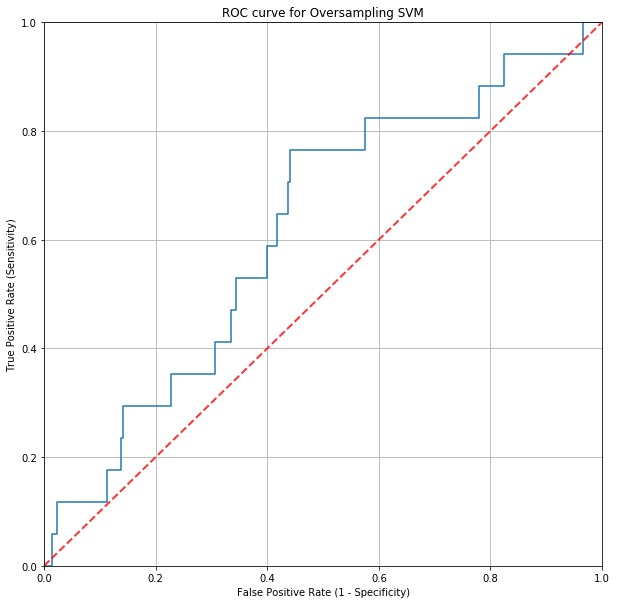

AUC score:  0.61874451273



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC
0,Logistic regression,0.940351,1.000000,0.000000,0.000000,0.911443,0.620281
1,Logistic regression balanced weights,0.649123,0.660448,0.470588,0.080808,0.741453,0.642450
2,Oversampling logistic regression,0.656140,0.660448,0.588235,0.099010,0.746580,0.651888
3,Oversampling logistic regression balanced weights,0.656140,0.660448,0.588235,0.099010,0.746580,0.651888
4,KNN,0.940351,1.000000,0.000000,0.000000,0.911443,0.621269
5,Oversampling KNN,0.561404,0.563433,0.529412,0.071429,0.672581,0.589552
6,SVM,0.940351,1.000000,0.000000,0.000000,0.911443,0.535996
7,SVM balanced weights,0.617544,0.619403,0.588235,0.089286,0.717176,0.635645
8,Oversampling SVM,0.592982,0.593284,0.588235,0.084034,0.697785,0.618745


In [107]:
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC"]
stats = []
for item in models:
    # Train-test split
    print(item['title'])
    
    # Train the model
    item['model'].fit(X_train, y_train)

    # Classifiy test examples
    predictions = item['model'].predict(X_test)
    print()

    # Print the accuracy score of the model
    print("Accuracy: ", accuracy_score(y_test, predictions))

    print()

    # Print the classification report of the model
    print(classification_report(y_test, predictions))

    # Print the confusion matrix
    
    print("Confusion matrix: ")
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    
    # ROC curve
    y_pred_prob = item['model'].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.plot([0,0],[1,1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.title('ROC curve for ' + item['title'])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

    # AUC score
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob))
    
    print()
    
    accuracy = accuracy_score(y_test, predictions)
    specificity = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],accuracy, specificity, recall, precision, f1, auc]
    stats.append(newRow)
stats_df = pd.DataFrame(stats, columns = stats_columns)
stats_df

# 10 Fold Cross Validation

Logistic regression


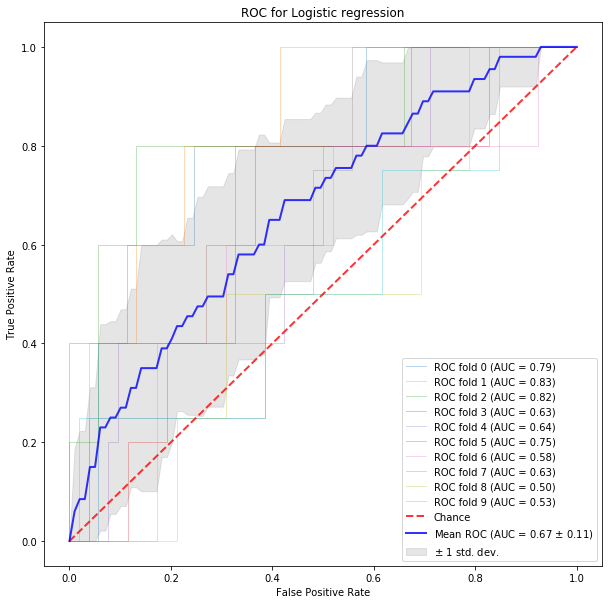

Accuracy mean:  0.917621640308

Logistic regression balanced weights


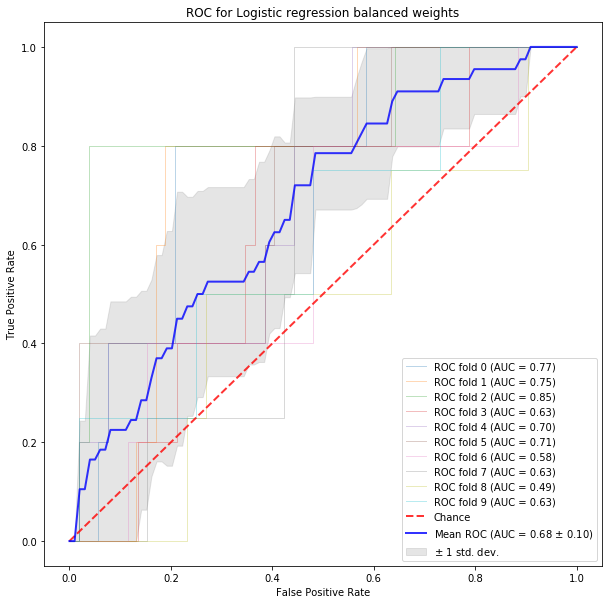

Accuracy mean:  0.638135208711

Oversampling logistic regression


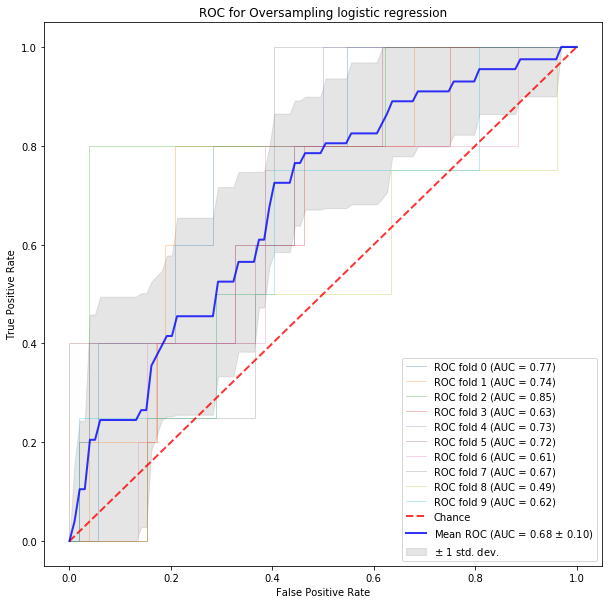

Accuracy mean:  0.661037291505

Oversampling logistic regression balanced weights


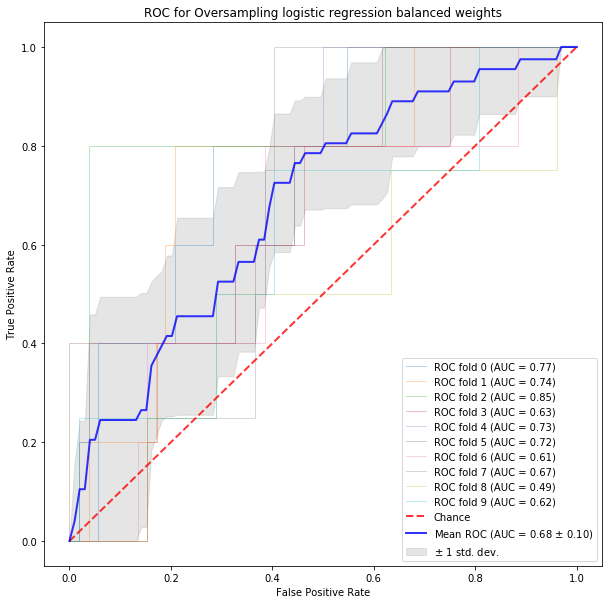

Accuracy mean:  0.661037291505

KNN


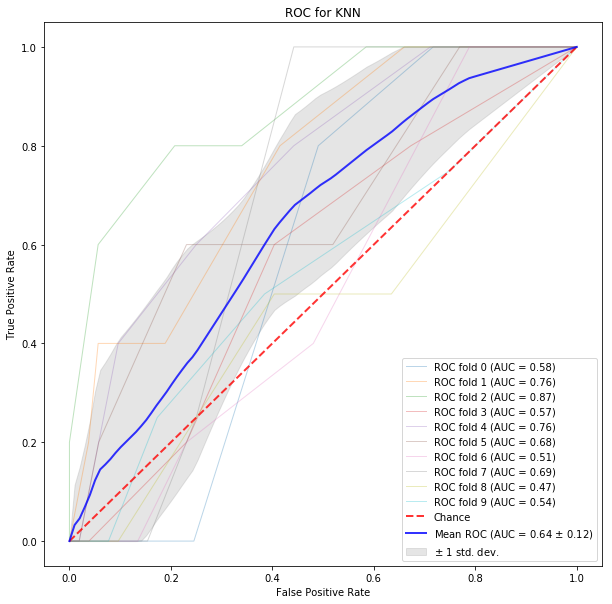

Accuracy mean:  0.917621640308

Oversampling KNN


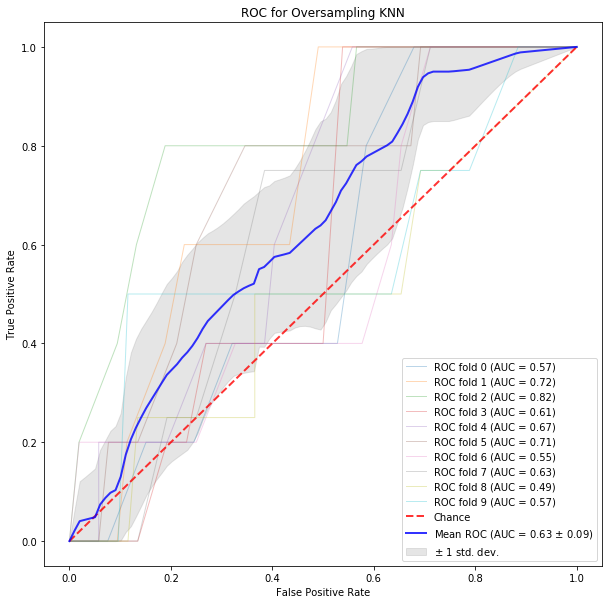

Accuracy mean:  0.571700803733

SVM


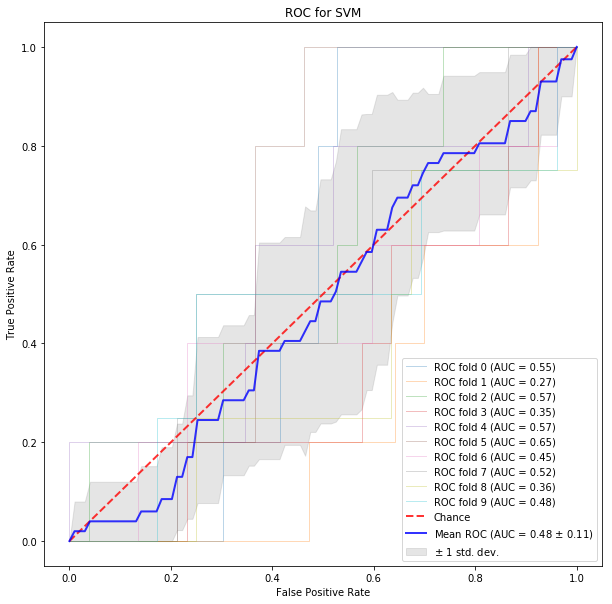

Accuracy mean:  0.917621640308

SVM balanced weights


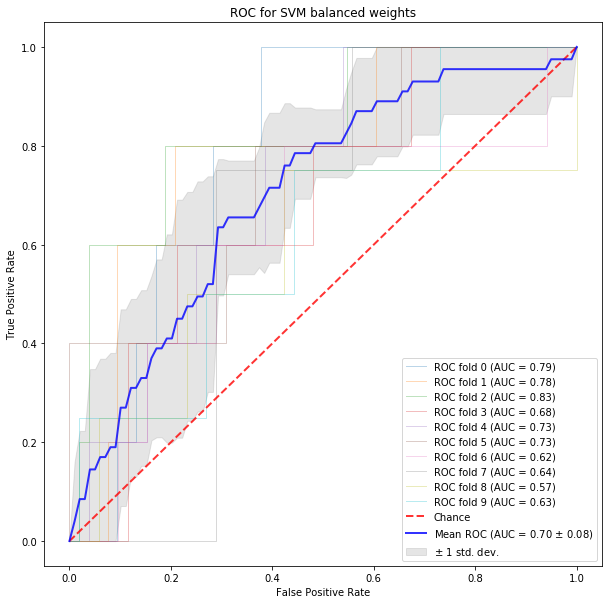

Accuracy mean:  0.610149295653

Oversampling SVM


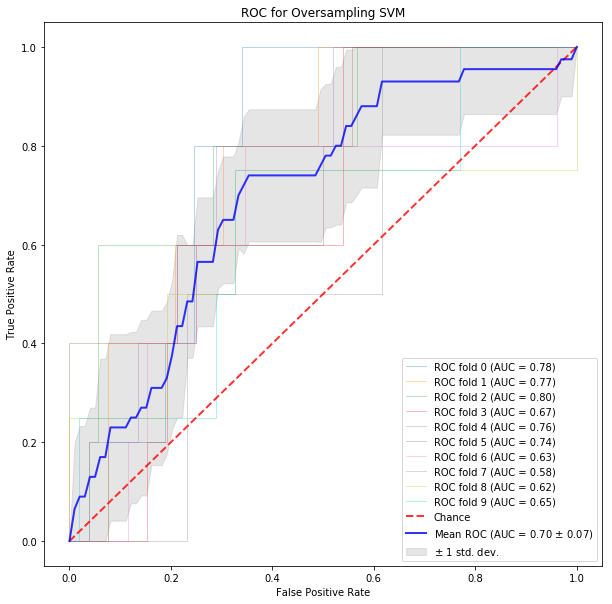

Accuracy mean:  0.634744188056



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC
0,Logistic regression,0.917622,1.000000,0.000,0.000000,0.878217,0.670051
1,Logistic regression balanced weights,0.638135,0.642090,0.585,0.133056,0.718484,0.675707
2,Oversampling logistic regression,0.661037,0.665094,0.610,0.142800,0.736066,0.683485
3,Oversampling logistic regression balanced weights,0.661037,0.665094,0.610,0.142800,0.736066,0.683485
4,KNN,0.917622,1.000000,0.000,0.000000,0.878217,0.642411
5,Oversampling KNN,0.571701,0.571444,0.575,0.108109,0.665086,0.634489
6,SVM,0.917622,1.000000,0.000,0.000000,0.878217,0.477677
7,SVM balanced weights,0.610149,0.600109,0.720,0.141286,0.695953,0.702273
8,Oversampling SVM,0.634744,0.628882,0.700,0.146412,0.714843,0.700303


In [114]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=10)
cv_stats = []
for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        predicts = classifier.predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y[test], predicts)
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        accs.append(accuracy_score(y[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y[test], predicts))
        precisions.append(precision_score(y[test], predicts))
        f1s.append(f1_score(y[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df